#  Boosting

Бустинг представляет собой жадный алгоритм построения композиции алгоритмов. Основная идея заключается в том, чтобы, имея множество относительно слабых алгоритмов обучения, построить их хорошую линейную комбинацию. Он похож на бэггинг тем, что базовый алгоритм обучения фиксирован. Отличие состоит в том, что обучение базовых алгоритмов для композиции происходит итеративно, и каждый следующий алгоритм стремится компенсировать недостатки композиции всех предыдущих алгоритмов.

На примере бустинга стало ясно, что хорошим качеством могут обладать сколь угодно сложные композиции классификаторов, при условии, что они правильно настраиваются. Это развеяло существовавшие долгое время представления о том, что для повышения обобщающей способности необходимо ограничивать сложность алгоритмов. 

Впоследствии этот феномен бустинга получил теоретическое обоснование. Оказалось, что взвешенное голосование не увеличивает эффективную сложность алгоритма, а лишь сглаживает ответы базовых алгоритмов. Эффективность бустинга объясняется тем, что по мере добавления базовых алгоритмов увеличиваются отступы обучающих объектов. Причём бустинг продолжает раздвигать классы даже после достижения безошибочной классификации обучающей выборки.

Общая схема бустинга:
- Искомый ансамбль алгоритмов имеет вид $a(x) = \mbox{sign}(\sum_{t = 1}^T \alpha_t b_t(x))$, где $b_t$ - базовые алгоритмы.
- Ансамбль строится итеративно, оптимизируя на каждом шаге функционал $Q_t$, равный количеству ошибок текущей композиции на обучающей выборке.
- При добавлении слагаемого $\alpha_t b_t(x)$ в сумму, функционал $Q_t$ оптимизируется только по базовому алгоритму $b_t(x)$ и коэффициенту $\alpha_t$ при нём, все предыдущие слагаемые считаются фиксированными.
- Функционал $Q_t$ имеет вид суммы по объектам обучающей выборки пороговых функций вида $[y_i \sum_{j = 1}^t \alpha_j b_j(x_i) < 0]$, имеющих смысл "текущая композиция ошибается на объекте с номером $i$". Каждое такое слагаемое имеет вид "ступеньки" и является разрывной функцией. Для упрощения решения задачи оптимизации такая пороговая функция заменяется на непрерывно дифференцируемую оценку сверху. В итоге получается новый функционал $\hat{Q}_t \geqslant Q_t$, минимизация которого приводит к минимизации исходного функционала $Q_t$.

Используя различные аппроксимации для пороговой функции потерь $[z < 0]$, будем получать различные виды бустинга. Примеры:
- $e^{-z}$ - AdaBoost
- $\log_2(1 + e^{-z})$ - LogitBoost
- $(1 - z)^2$ - GentleBoost
- $e^{-cz(z+a)}$ - BrownBoost
- другие

Populating the interactive namespace from numpy and matplotlib


C:\Users\sanek\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


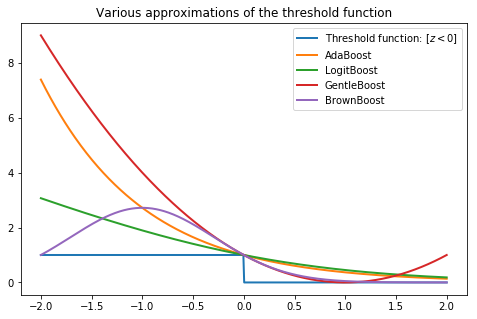

In [2]:
import numpy as np
%pylab inline
import matplotlib.pyplot as plt

x = np.linspace(-2, 2, 500)

plt.figure(figsize=(8,5))
plt.plot(x, x < 0, lw=2, label='Threshold function: $[z < 0$]')
plt.plot(x, np.exp(-x), lw=2, label='AdaBoost')
plt.plot(x, np.log2(1 + np.exp(-x)), lw=2, label='LogitBoost')
plt.plot(x, (1 - x) ** 2, lw=2, label='GentleBoost')
plt.plot(x, np.exp(-x * (x + 2)), lw=2, label='BrownBoost')
plt.title('Various approximations of the threshold function')
plt.legend(loc='best')

### Алгоритм AdaBoost

Как было сказано, алгоритм AdaBoost получается из описанной схемы, при аппроксимации пороговой функции потерь с помощью функции $e^{-z}$. Cуществует теорема (Freund, Schapire, 1996), дающая для достаточно богатых семейств базовых классификаторов явные формулы для базового алгоритма $b_t(x)$ и коэффициента $\alpha_t$ при нём, на которых достигается минимум функционала $\hat{Q}_t$. 

Сам алгоритм выглядит следующим образом:
- Инициализировать веса объектов $w_i = \frac{1}{l}, i = 1, \dots, l$.
- Для всех $t = 1, \dots, T$
    * Обучить базовый алгоритм $b_t = \arg \min_b N(b, W^l)$, где $N(b, W^l)$ есть взвешенная сумма ошибочных классификаций для $b_t$.
    * $\alpha_t = \frac{1}{2}\frac{1 - N(b_t, W^l)}{N(b_t, W^l)}$.
    * Обновить веса объектов: $w_i = w_i e^{-\alpha_t y_i b_t(x_i)}, i = 1, \dots, l$.
    * Нормировать веса объектов: $w_0 = \sum_{j = 1}^k w_j, w_i = \frac{w_i}{w_0}, i = 1, \dots, l$.
    
Таким образом, вновь добавляемый алгоритм обучается путём минимизации взвешенной частоты ошибок на обучающей выборке, а не стандартного функционала, равного частоте ошибок. Вес объекта увеличивается в $e^{\alpha_t}$ раз, когда $b_t$ допускает на нём ошибку, и уменьшается во столько же раз, когда $b_t$ правильно классифицирует этот объект. Таким образом, непосредственно перед настройкой базового алгоритма наибольший вес накапливается у тех объектов, которые чаще оказывались трудными для классификации предыдущими алгоритмами.

<img src="./img/boosting_overfitting.png">

Сначала было обнаружено отстутствие переобучения бустинга вплоть до 1000 базовых классификаторов, похже это было теоретически обосновано. 

### Gradient boosting
Метод градиентного бустинга в некотором смысле является обобщением остальных методов бустинга, поскольку он позволяет оптимизировать произвольную дифференцируемую функцию потерь. Данный алгоритм похож на метод градиентного спуска, применяемый для решения задач оптимизации. Основная идея заключается в том, что каждый следующий добавляемый в композицию алгоритм настраивается на остатки предыдущих алгоритмов.

Пусть дана функция потерь дифференцируемая $L(F(x), y)$. Сам алгоритм выглядит следующим образом:
- Инициализация композиции константным значением $F_0(x) = \arg\min_{\alpha} \sum_{i=1}^n L(\alpha, y_i)$.
- Для всех $t = 1, \dots, T$:
    * Вычислить остатки предыдущей композиции: $r_{it} = -[\nabla_{F(x)} L(F(x_i), y_i)]_{F(x) = F_{t-1}(x)}, i = 1, \dots, n$.
    * Настроить базовый алгоритм $b_t(x)$ на полученные остатки, т.е. обучить его по выборке $\{(x_i, r_{it}), i = 1, \dots, n\}$.
    * Вычислить коэффициент $\alpha_t$ перед базовым алгоритмом $b_t(x)$ как решение следующей одномерной задачи оптимизации:
    $\alpha_t = \arg\min_\alpha \sum_{i=1}^n L(F_{t-1}(x_i) + \alpha b_t(x_i), y_i)$.
    * Добавить полученное слагаемое в композицию: $F_t(x) = F_{t-1}(x) + \alpha_t b_t(x)$.
    
Одной из возможных модификаций данного алгоритма является стохастический градиентный бустинг (SGB), который заключается в том, чтобы вычислять суммы вида $\sum_{i=1}^n$ не по всей обучающей выборке, а только по некоторой её случайной подвыборке. Такой подход является одним из способов регуляризации данного алгоритма и позволяет улучшить качество композиции, сходимость алгоритма и время обучения. 

Другой способ регуляризации - это введение параметра $\gamma$, называемого темпом обучения. При добавлении нового слагаемого в композицию, будем добавлять его, умноженное на этот коэффициент. Как правило, чем меньше темп обучения, тем лучше качество итоговой композиции.

Для задач регресси обычно использую квадратичную функцию потерь $L(x, y) = (x - y)^2$ или модуль отклонения $L(x, y) = |x - y|$.
В задаче классификации используется логистическая функция потерь, которая позволяет возвращать вероятности принадлежности объектов к классам.

Одним из наиболее популярных семейств базовых алгоритмов являются решающие деревья. Именно такой вариант градиентного бустинга <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html">реализован</a> в sklearn.

## Примеры

В sklearn доступны алгоритмы AdaBoost и GradientBoosting для задач классификации и регрессии.
В качестве примера рассмотрим решение задачи восстановления одномерной регрессии с помощью <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html">GradientBoostingRegressor</a>.

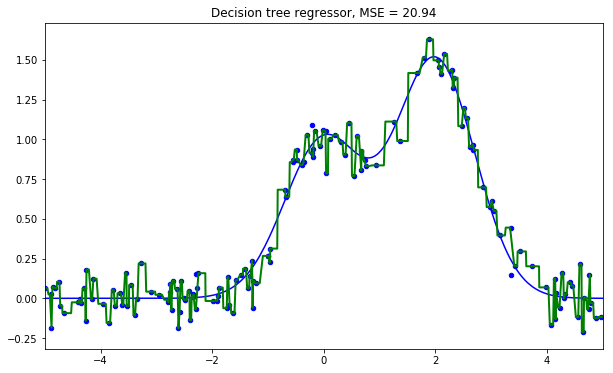

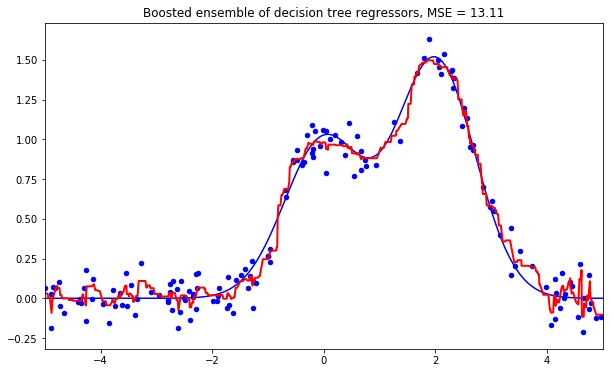

In [3]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
     
n_train = 150        
n_test = 1000       
noise = 0.1

# Generate data
def f(x):
   # http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.ravel.html 
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) +\
        np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)
# One decision tree regressor
dtree = DecisionTreeRegressor()

dtree.fit(X_train, y_train)
d_predict = dtree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, d_predict, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree regressor, MSE = %.2f" % 
          np.sum((y_test - d_predict) ** 2))

gbtree = GradientBoostingRegressor(n_estimators=100, subsample=0.5)  
gbtree.fit(X_train, y_train)
gb_predict = gbtree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, gb_predict, "r", lw=2)
plt.xlim([-5, 5])
plt.title("Boosted ensemble of decision tree regressors, MSE = %.2f" % 
          np.sum((y_test - gb_predict) ** 2))

Рассмотрим пример использования AdaBoostClassifier с деревья решений единичной глубины (decision stumps) в качестве базовых алгоритмов для решения задачи классификации.

In [5]:
from urllib.request import urlopen
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Loading Pima Indians Diabetes data from UCI Machine learning repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
raw_data = urlopen(url)
data = np.loadtxt(raw_data, delimiter=",")

X_train, X_test, y_train, y_test = train_test_split(data[:, :8], 
                                                    data[:, 8], 
                                                    random_state=0)

dt = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

# AdaBoost
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         random_state=0).fit(X_train, y_train)

print("Decision tree accuracy: %.2f" % dt.score(X_test, y_test))
print("AdaBoost accuracy: %.2f" % ada.score(X_test, y_test))

Decision tree accuracy: 0.72
AdaBoost accuracy: 0.79


## Полезные ссылки
- <a href="https://en.wikipedia.org/wiki/Boosting_(machine_learning)">Boosting</a>
- [Gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting)
- [Лекция](http://www.machinelearning.ru/wiki/images/c/cd/Voron-ML-Compositions-slides.pdf) К.В. Воронцова по композиционным методам классификации
- <a href="https://github.com/dmlc/xgboost">Xgboost</a>
- <a href="https://github.com/ChenglongChen/Kaggle_CrowdFlower">Обзор</a> решения победителя соревнования Kaggle "CrowdFlower" по предсказанию релевантности выдачи поисковика товаров. Решение на основе Xgboost